In [3]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import regex as re
import pandas as pd
import numpy as np
from pathlib import Path
from transformers import AutoModel, AutoTokenizer, logging
from datasets import load_dataset
from copy import deepcopy

from outliersvsfreq.pyplot.plotting_correlation import stack_plot_corr, stack_plot_freq
from outliersvsfreq.parameter_hiding import zero_param_

model_name = "bert-base-uncased"

if model_name == "roberta-base":
    outliers_idxs = [77, 588]
elif model_name == "bert-base-uncased":
    outliers_idxs = [308, 381]

/home/nlp/anaconda3/envs/outliersvsfreq/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# output_path = Path("./output/baselines/evaled/mberts_1/checkpoints/")
# mberts_df = pd.DataFrame()
# ckpts = sorted([i for i in output_path.iterdir()], key=lambda x: int(re.search("step_(\d+)", str(x)).group(1)))
# for i in ckpts[1:]:
#     with open(i.resolve() / "NLI" / "ep_003_smpl_1M" / "hf"/ "layer_size_12_results.json") as new_file_path:
#         new_file = json.load(new_file_path)
#     new_df = pd.DataFrame.from_dict(new_file).T.applymap(lambda x:x['eval_accuracy'])
#     mberts_df = pd.concat([mberts_df, new_df])
# mberts_df = mberts_df.rename({"(218,)": "218"}, axis=1).rename({"(674,)": "674"}, axis=1).rename({"": "Full Model"})

In [5]:
def select_func(x):
    if "eval_pearson" in x:
        return x["eval_pearson"]
    elif "eval_matthews_correlation" in x:
        return x["eval_matthews_correlation"]
    elif "eval_accuracy" in x:
        return x["eval_accuracy"]
    
    
dfs = []
names = []
for path in Path("./output/baselines/scores/bert-base-uncased/").iterdir():
    with open(path / "n_layers_with_hidden_outliers_12_results.json") as input_path:
        dfs.append(pd.DataFrame.from_dict(json.load(input_path)).applymap(select_func).T)
        names.append(path.name)
# dfs.append(dfs[0])
glue_df = pd.concat(dfs)
glue_df.index = names
glue_df.T

FileNotFoundError: [Errno 2] No such file or directory: 'output/baselines/scores/bert-base-uncased'

In [18]:
future_table = []
idxs = ['187', '759', 'random_len_1', '759_187', 'random_len_2']
for experiment in ['cifar10', 'cifar100']:
    cifar_path = Path(f"output/vit/{experiment}")
    cifar_result = list(cifar_path.iterdir())[-1]
    with open(cifar_result / "eval_output.json") as input_file:
        future_table.append(pd.DataFrame.from_dict({experiment:{i:j for i,j in json.load(input_file).items() if i in idxs}}))
pd.concat(future_table, axis=1)

,cifar10,cifar100
187,0.97930,0.90240
759,0.98020,0.91620
759_187,0.97650,0.84020
random_len_1,0.98102,0.91906
random_len_2,0.98040,0.91788


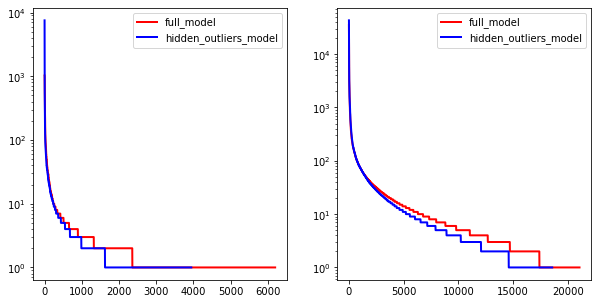

In [26]:
rob_df_path = "output/data_experiments/generation_output/roberta-base_[77, 588]_all_tokens_in_a_row.csv"
bert_df_path = "output/data_experiments/generation_output/bert-base-uncased_[308, 381]_all_tokens_in_a_row.csv"
rob_df = pd.read_csv(rob_df_path, dtype={"tokens":str, "gen_toks":str, "freq_change":int, "abs_change":int, "real_freq":int, "gen_freq":int})
bert_df = pd.read_csv(bert_df_path, dtype={"tokens":str, "gen_toks":str, "freq_change":int, "abs_change":int, "real_freq":int, "gen_freq":int})
rob_real_freqs = np.sort(np.unique(rob_df.tokens.astype(str).values, return_counts=True)[1])[::-1]
rob_gen_freqs = np.sort(np.unique(rob_df.gen_toks.astype(str).values, return_counts=True)[1])[::-1]
bert_real_freqs = np.sort(np.unique(bert_df.tokens.astype(str).values, return_counts=True)[1])[::-1]
bert_gen_freqs = np.sort(np.unique(bert_df.gen_toks.astype(str).values, return_counts=True)[1])[::-1]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for idx, (name, real_freqs, gen_freqs) in enumerate([("roberta-base", rob_real_freqs, rob_gen_freqs), ("bert-base-uncased", bert_real_freqs, bert_gen_freqs)]):
    ax[idx].plot(real_freqs, label="full_model", linewidth=2, color="red")
    ax[idx].plot(gen_freqs, label="hidden_outliers_model", linewidth=2, color='blue')
    ax[idx].set_yscale('log')
    ax[idx].legend()

In [27]:
freqs = torch.load(f"output/outlier_correlations/{model_name}/freqs.bin")
hidden_states_special = torch.load(f"output/outlier_correlations/{model_name}/hidden_states_special.bin")
attention_special = torch.load(f"output/outlier_correlations/{model_name}/attentions_special.bin")
masks_special = torch.load(f"output/outlier_correlations/{model_name}/masks_special.bin")

hidden_states_no_special = torch.load(f"output/outlier_correlations/{model_name}/hidden_states_no_special.bin")
attention_no_special = torch.load(f"output/outlier_correlations/{model_name}/attentions_no_special.bin")
masks_no_special = torch.load(f"output/outlier_correlations/{model_name}/masks_no_special.bin")

(<Figure size 360x360 with 1 Axes>, <AxesSubplot:>)

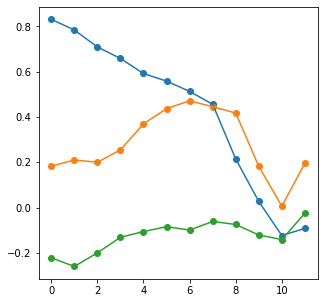

In [28]:
stack_plot_freq(
    freqs, {j:[torch.abs(i) for i in k] for j,k in hidden_states_special.items()}, masks_special,
    outliers_idxs=outliers_idxs, random_dims=set(hidden_states_special.keys()).difference([308, 381])
)

(<Figure size 360x360 with 1 Axes>, <AxesSubplot:>)

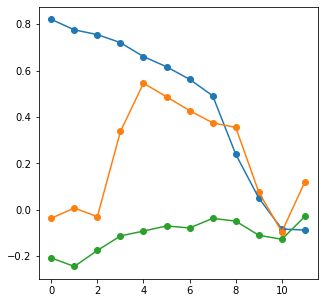

In [29]:
stack_plot_freq(
    freqs, {j:[torch.abs(i) for i in k] for j,k in hidden_states_no_special.items()}, masks_no_special,
    outliers_idxs=outliers_idxs, random_dims=set(hidden_states_special.keys()).difference([308, 381])
)

(<Figure size 720x360 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

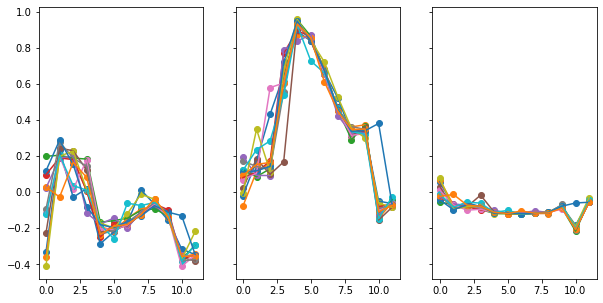

In [30]:
stack_plot_corr(
    {j:[torch.abs(i) for i in k] for j,k in hidden_states_special.items()}, attention_special, masks_special, 
    outliers_idxs=outliers_idxs, random_dims=set(hidden_states_special.keys()).difference([308, 381])
)

(<Figure size 720x360 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

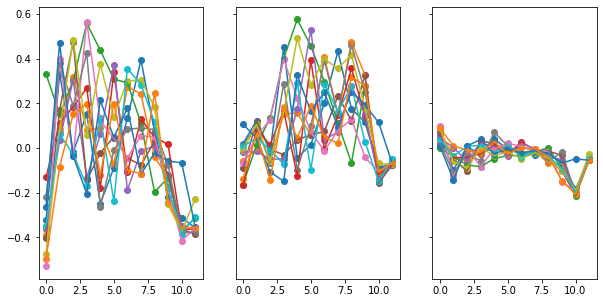

In [31]:
stack_plot_corr(
    {j:[torch.abs(i) for i in k] for j,k in hidden_states_no_special.items()}, attention_no_special, masks_no_special, 
    outliers_idxs=outliers_idxs, random_dims=set(hidden_states_no_special.keys()).difference([308, 381])
)

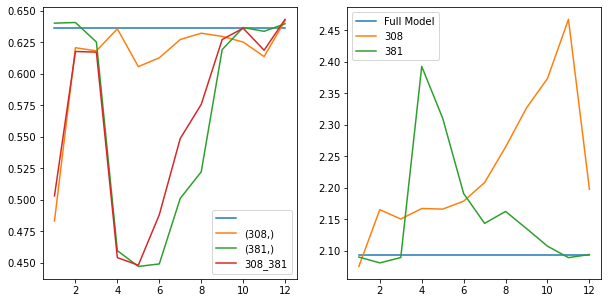

In [33]:
if model_name == "bert-base-uncased":
    col_order = ["308", "381", "308, 381", "Full Model"]
elif model_name == "roberta-base":
    col_order = ["77", "588", "77, 588", "Full Model"]

with open(f"output/baselines/scores/{model_name}/mnli/n_layers_with_hidden_outliers_1_results.json") as nli_file:
    nli_scores = json.load(nli_file)
with open(f"output/mlm_loss/{model_name}/results_by_layer.json") as mlm_file:
    mlm_loss = json.load(mlm_file)

df_score = pd.DataFrame.from_dict(nli_scores).applymap(lambda x: x["eval_accuracy"]).T
df_score.reset_index(drop=True, inplace=True)
df_score.index = df_score.index + 1

df_loss = pd.DataFrame.from_dict(mlm_loss).T
df_loss.reset_index(drop=True, inplace=True)
df_loss.rename({"":"Full Model"}, axis=1, inplace=True)
df_loss.drop("_".join(str(i) for i in outliers_idxs), axis=1, inplace=True)
df_loss.index = df_loss.index + 1

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
df_score.plot(ax=ax[0])
df_loss.plot(ax=ax[1]);

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Reusing dataset glue (/home/nlp/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|████████

Thebes held onto power until the 12th Dynasty, when its first king, Amenemhet Iwho reigned between 1980 1951 b.c. established a capital near Memphis.
The capital near Memphis lasted only half a century before its inhabitants abandoned it for the next capital. 
Ignored unknown kwarg option direction


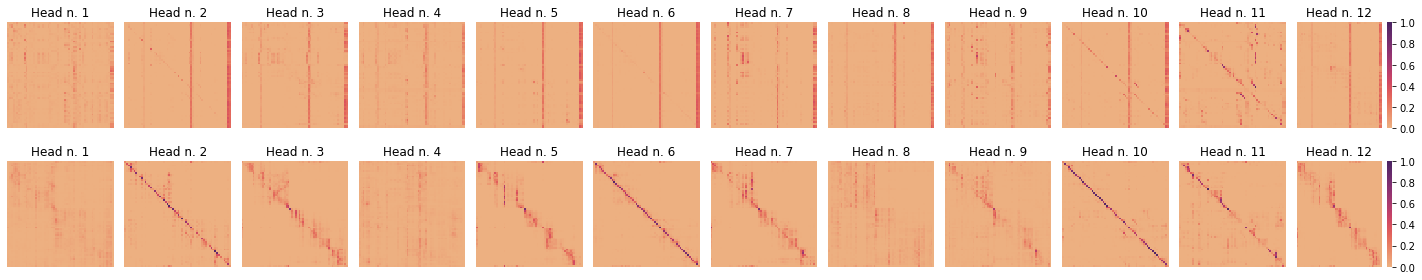

In [34]:
fig_nrows = 2
fig_ncols = 12

model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
newmodel = deepcopy(model)
newmodel = zero_param_(newmodel, outliers_idxs)


ds = load_dataset("glue", "mnli")

sent_idx = 13
sentence1 = ds["train"]["premise"][sent_idx]
sentence2 = ds["train"]["hypothesis"][sent_idx]

print(sentence1)
print(sentence2)

tokenized = tokenizer(sentence1, sentence2, return_tensors="pt", truncation=True,)

att_plot_idx = 10

palette = sns.color_palette("flare", as_cmap=True)

att_fig1, ax = plt.subplots(fig_nrows, fig_ncols, figsize=(20, 4))
atts = [
    model(**tokenized, output_attentions=True).attentions[att_plot_idx],
    newmodel(**tokenized, output_attentions=True).attentions[att_plot_idx]
]
for j in range(2):
    for i in range(12):
        sns.heatmap(atts[j][0, i, :].detach(), ax=ax[j, i], vmin=0, vmax=1, cmap=palette, cbar=i==11)
        ax[j, i].axis('off')
        ax[j, i].set_title(f"Head n. {i + 1}")


plt.tight_layout()